# Viscous streaming solution in frequency domain

In this notebook, we seek to solve for viscous streaming in the frequency domain.

$$ \mathcal{L}_\alpha u = i\alpha u  - L u = f $$

where $\alpha$ is a real-valued constant, $L$ is the grid Laplacian operator, and $u$ is a complex-valued field on the grid. It should be noted that $\alpha = \omega \Delta x^2/\nu$, where $\omega$ is a frequency, $\nu$ is kinematic viscosity, and $\Delta x$ is the grid spacing. The operator $\mathcal{L}_\alpha$ we will call the Helmholtz operator.

In [1]:
using Pkg

In [1]:
using Plots

In [2]:
using Revise

In [3]:
using ViscousStreaming

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.2/ViscousStreaming/UPKy8.ji for ViscousStreaming [47fb7046-13b0-40db-b6a6-74fa44cf0959]
└ @ Base loading.jl:1240


In [51]:
Re = 40
ϵ = 0.1

0.1

### Set up analytical solution

In [52]:
p = StreamingParams(ϵ,Re)

Streaming flow parameters with Re = 40.0, ϵ = 0.1


In [6]:
s = StreamingAnalytical(p)

Maximum residual on W₁ = 5.684341886080801e-13
BC residual on Ψ₁(1) = 2.237726045655905e-16
BC residual on dΨ₁(1) = 6.684427777288334e-16
Maximum residual on Ws₂ = 1.944044925039634e-11
BC residual on Ψs₂(1) = 1.7763568394002505e-15
BC residual on dΨs₂(1) = 4.440892098500626e-15
Maximum residual on W₂ = 5.075324744564049e-12
BC residual on Ψ₂(1) = 7.757919228897728e-17
BC residual on dΨ₂(1) = 8.881784197001252e-16


Analytical streaming flow solution for
single cylinder with Re = 80.0, ϵ = 0.1


### Set up the basic system

#### Set up the grid cell size and approximate dimensions

In [53]:
Δx = 0.02
xlim = (-5.98,5.98)
ylim = (-5.98,5.98)

(-5.98, 5.98)

#### Set up a body

In [54]:
n = 150
body = Circle(1.0,n)

Circular body with 150 points and radius 1.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


In [55]:
@time solver1 = FrequencyStreaming(Re,ϵ,Δx,xlim,ylim,body);

 88.651697 seconds (366.53 M allocations: 42.566 GiB, 16.30% gc time)


In [56]:
soln = solver1([1.0,0.0],body);

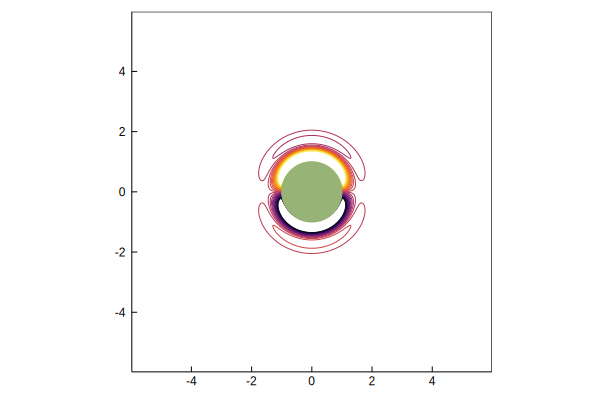

In [57]:
xg, yg = coordinates(soln.s1.W,solver1.grid)
plot(xg,yg,vorticity(0,soln.s1),levels=range(-2,2,length=30),clim=(-2,2),xlim=xlim,ylim=ylim)
plot!(body)

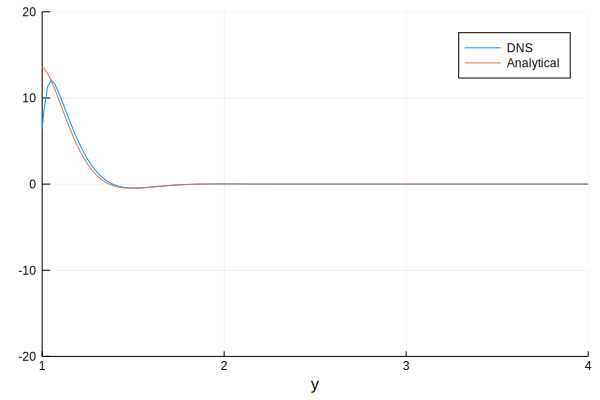

In [13]:
ix = 301
plot(yg,vorticity(0,soln.s1)[301,:],ylim=(-20,20),xlim=(1,4),label="DNS",xlabel="y")
plot!(yg,map(y -> vorticity(xg[ix],y,0.0,firstorder(s)),abs.(yg)),label="Analytical")

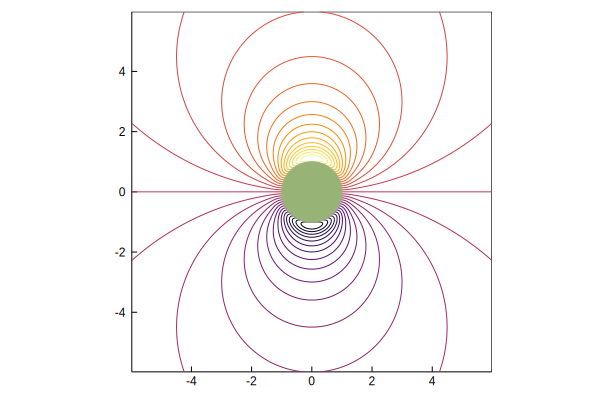

In [14]:
plot(xg,yg,streamfunction(0,soln.s1),levels=range(-1,1,length=31),xlim=xlim,ylim=ylim)
plot!(body)

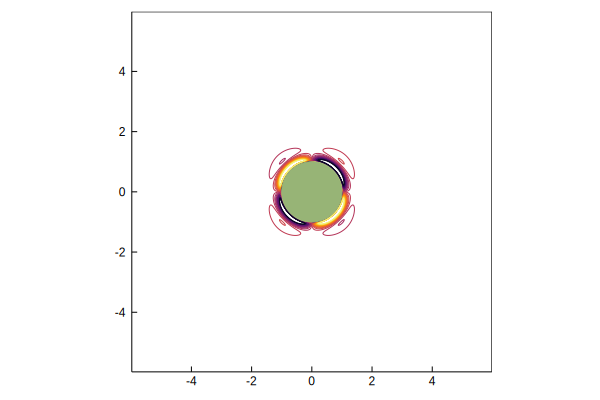

In [15]:
plot(xg,yg,vorticity(soln.s̄2),levels=range(-10,10,length=30),clim=(-10,10),xlim=xlim,ylim=ylim)
plot!(body)

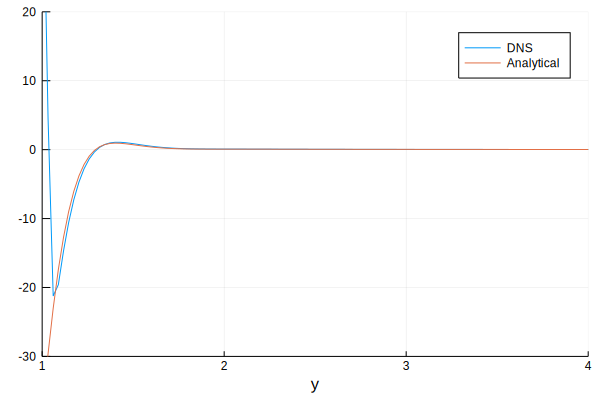

In [16]:
rg = sqrt.(xg.^2+yg.^2)
plot(rg,map(ix -> vorticity(soln.s̄2)[ix,ix],1:length(rg)),ylim=(-30,20),xlim=(1,4),label="DNS",xlabel="y")
plot!(rg,map(x -> vorticity(x,x,secondordermean(s)),xg),label="Analytical")

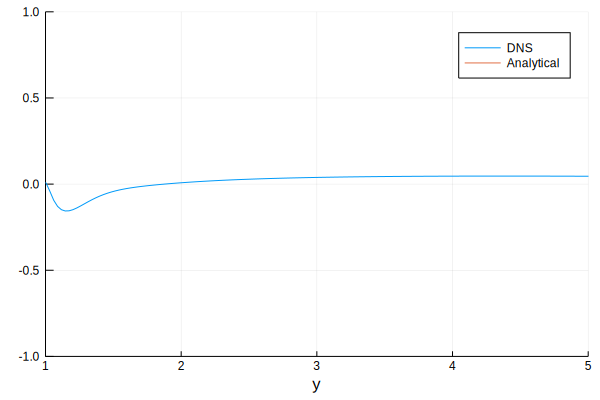

In [17]:
ig = 120
rg = sqrt.(xg[ig:end].^2+yg[ig:end].^2)
plot(rg,map(ix -> streamfunction(soln.s̄2)[ix,ix],ig:length(xg)),ylim=(-1,1),xlim=(1,5),label="DNS",xlabel="y")
#plot!(rg,map(ix -> Δx*real(s22)[ix,ix],ig:length(xg)),ylim=(-1,1),xlim=(0.5,2),label="DNS",xlabel="y")
plot!(rg,map(x -> streamfunction(x,x,secondordermean(s)),xg[ig:end]),label="Analytical")

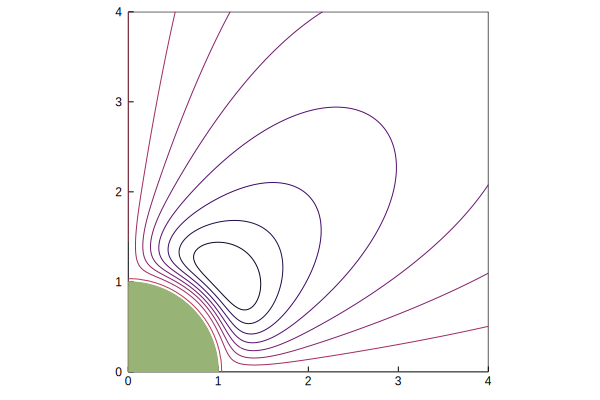

In [83]:
plot(xg,yg,lagrangian_mean_streamfunction(soln),levels=15,xlim=(0,4),ylim=(0,4))
plot!(body)

### Now multiple bodies

In [150]:
bl = BodyList()

BodyList(Body[])

In [151]:
bL = deepcopy(body)
bR = deepcopy(body)

Circular body with 150 points and radius 1.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


In [153]:
# left cylinder
cent = (-3.0,0.0)
α = 0.0
TL = RigidTransform(cent,α)
TL(bL) # transform the body to the current configuration

# right cylinder
cent = (3.0,0.0)
α = 0.0
TR = RigidTransform(cent,α)
TR(bR) # transform the body to the current configuration

push!(bl,bL)
push!(bl,bR)

2-element Array{Body,1}:
 Circular body with 150 points and radius 1.0
   Current position: (-3.0,0.0)
   Current angle (rad): 0.0

 Circular body with 150 points and radius 1.0
   Current position: (3.0,0.0)
   Current angle (rad): 0.0
 

#### Set up the system

In [154]:
@time solver2 = FrequencyStreaming(Re,ϵ,Δx,xlim,ylim,bl);

197.680179 seconds (1.47 G allocations: 103.494 GiB, 18.00% gc time)


In [220]:
soln = solver2([[0.0,0.0],[0.0,1.0]],bl);

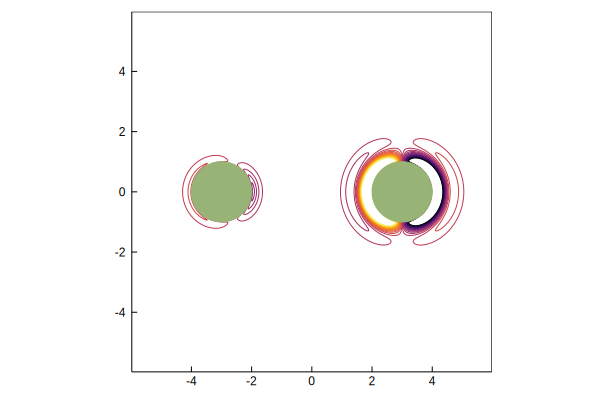

In [221]:
xg, yg = coordinates(soln.s1.W,soln.g)
plot(xg,yg,vorticity(0,soln.s1),levels=range(-2,2,length=30),clim=(-2,2),xlim=xlim,ylim=ylim)
plot!(bl)

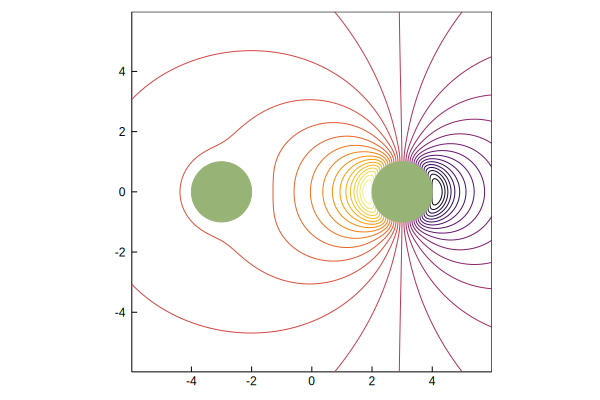

In [222]:
plot(xg,yg,streamfunction(0,soln.s1),levels=range(-1,1,length=31),xlim=xlim,ylim=ylim)
plot!(bl)

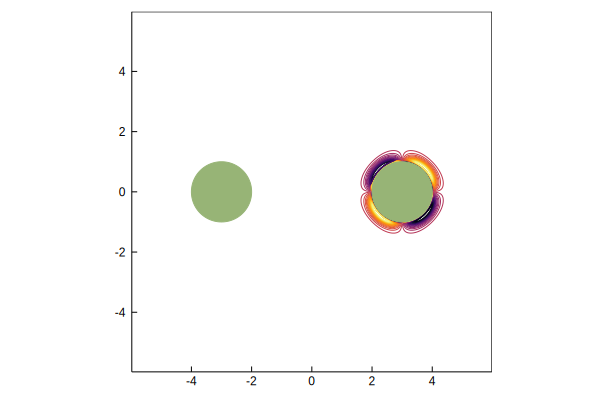

In [223]:
plot(xg,yg,vorticity(soln.s̄2),levels=range(-10,10,length=30),clim=(-10,10),xlim=xlim,ylim=ylim)
plot!(bl)

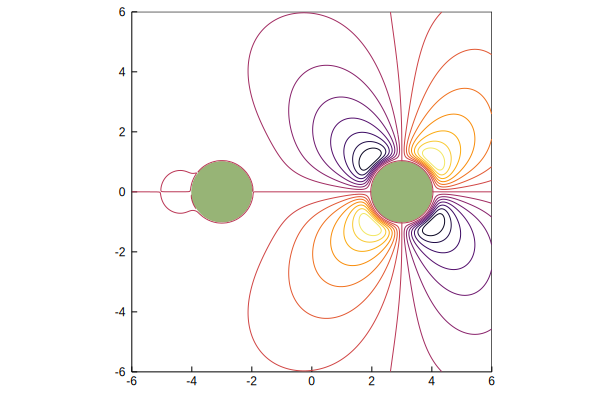

In [224]:
plot(xg,yg,lagrangian_mean_streamfunction(soln),levels=15,xlim=(-6,6),ylim=(-6,6))
plot!(bl)

### Inertial particle transport

In [225]:
p_inert = InertialParameters(tau=0.1,beta=0.95,epsilon=ϵ,Re=Re)

InertialParameters(0.95, 0.1, 0.1, 40)

In [226]:
soln_inertial = inertial_velocity(soln,p_inert);

In [227]:
v̄L = lagrangian_mean_velocity(soln_inertial);

In [228]:
RangexuxCFD, RangeyuxCFD = coordinates(v̄L.u, soln_inertial.g)
RangexuyCFD, RangeyuyCFD = coordinates(v̄L.v, soln_inertial.g)

(-5.98:0.02:5.98, -5.99:0.02:5.99)

In [229]:
v̄Luxy = CubicSplineInterpolation((RangexuxCFD, RangeyuxCFD),v̄L.u, extrapolation_bc = (Flat(),Flat()))
v̄Lvxy = CubicSplineInterpolation((RangexuyCFD, RangeyuyCFD),v̄L.v, extrapolation_bc = (Flat(),Flat()))
nothing

In [230]:
function v̄Lfcn(dR,R,p,t)
    
   dR[1] = v̄Luxy(R[1],R[2])
   dR[2] = v̄Lvxy(R[1],R[2])
    
   return dR 
end

v̄Lfcn (generic function with 1 method)

In [235]:
X₀ = (-2.0,2.0)
Ω = 1.0
Tp = 2π/Ω
Tmax = 105000*Tp

659734.4572538566

In [236]:
bl[1].cent

(-3.0, 0.0)

In [237]:
solL = compute_trajectory(v̄Lfcn,X₀,Tmax,10Tp,bl=bl,ϵ=p.ϵ);

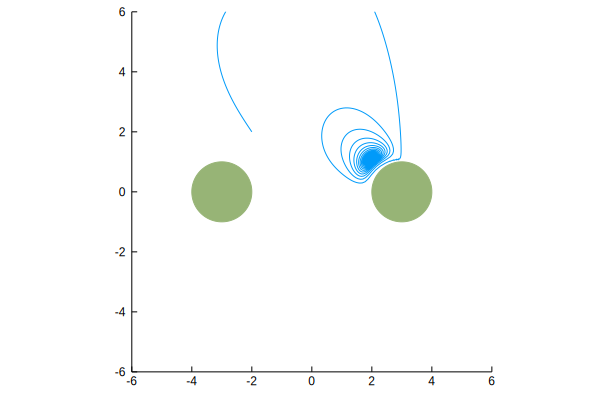

In [238]:
plot(solL[1,:],solL[2,:],ratio=1,legend=false,linewidth=1,xlim=(-6,6),ylim=(-6,6))
plot!(bl)
#plot!(xg,yg,lagrangian_mean_streamfunction(soln),levels=15,xlim=(0,4),ylim=(0,4))

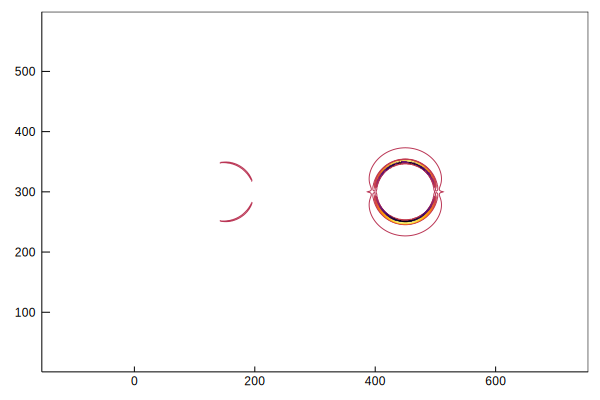

In [219]:
plot(divergence(v̄L),levels=31)